# Low-Rank Approximation Fine-Tuning

This notebook demonstrates encrypted fine-tuning of a small MLP model with LoRA. A model trained on an initial dataset is adapted to a second dataset using LoRA fine-tuning.

The fine-tuning dataset and the trained LoRA weights are protected using encryption. Thus, training can be securely outsourced to a remote server without compromising any sensitive data.

The hybrid approach is applied to fine-tuning: only the linear layers of the original model are outsourced to the server. The forward and backward passes on these layers are performed using encrypted activations and gradients. Meanwhile, the LoRA weights are kept by the client, which performs locally the forward and backward passes on the LoRA weights.

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_circles, make_moons
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from concrete.ml.torch.lora import LoraTrainer

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED);

/root/actions-runner/_work/concrete-ml/concrete-ml/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Data preparation

Two datasets are generated: one for the original training, and a second one on which LoRA fine-tuning is performed.

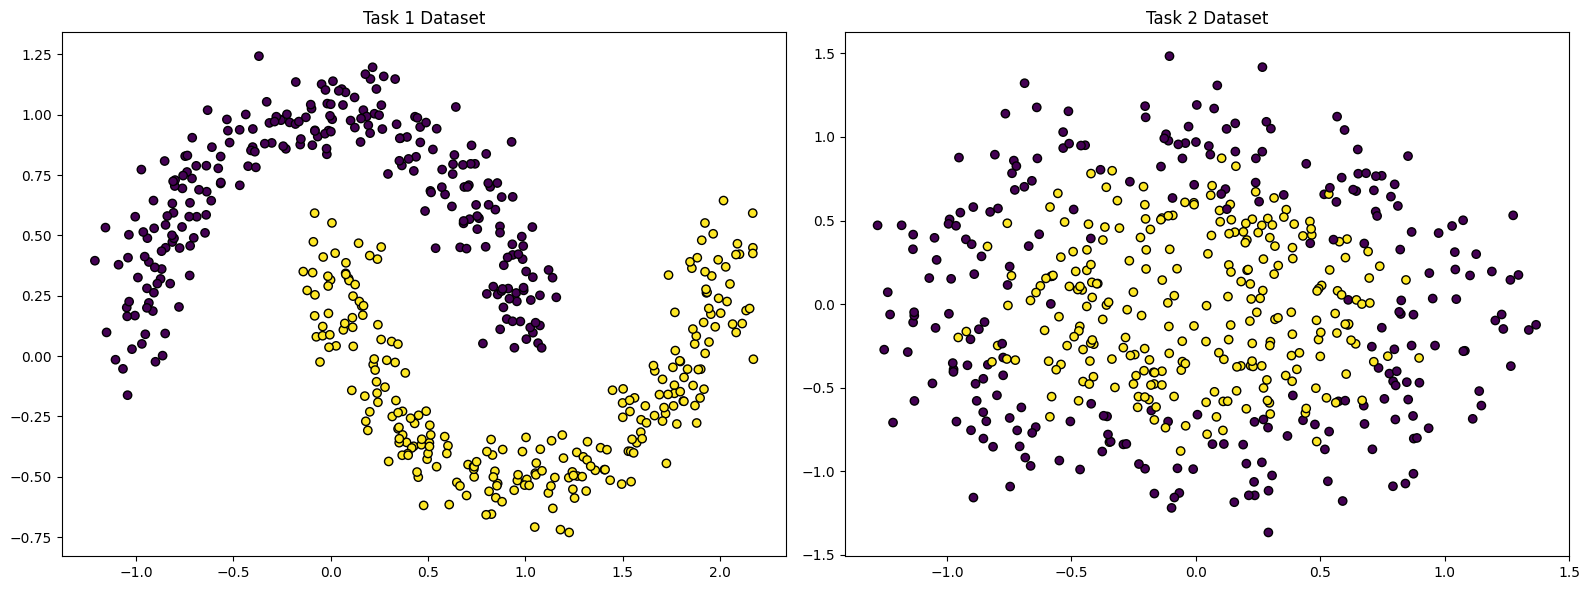

In [2]:
# Task 1: Two interleaving half circles
X_task1, y_task1 = make_moons(n_samples=500, noise=0.1)
# Task 2: Two concentric circles
X_task2, y_task2 = make_circles(n_samples=500, noise=0.2, factor=0.5)


def plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2, model=None, titles=None):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    if titles is None:
        titles = ["Task 1 Dataset", "Task 2 Dataset"]

    for ax, X, y, title in zip([ax1, ax2], [X_task1, X_task2], [y_task1, y_task2], titles):
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k")
        ax.set_title(title)

        if model is not None:
            x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
            y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
            h = 0.1  # step size in the mesh
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

            with torch.no_grad():
                Z = model(grid)
                probabilities = torch.softmax(Z, dim=1)
                Z = probabilities[:, 1].numpy().reshape(xx.shape)

            ax.contourf(xx, yy, Z, cmap="viridis", alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot datasets
plot_datasets_and_boundaries(X_task1, y_task1, X_task2, y_task2)

## Create the original MLP and test it

Training on Task 1 without LoRA:


Epoch [20/20], Loss: 0.0036


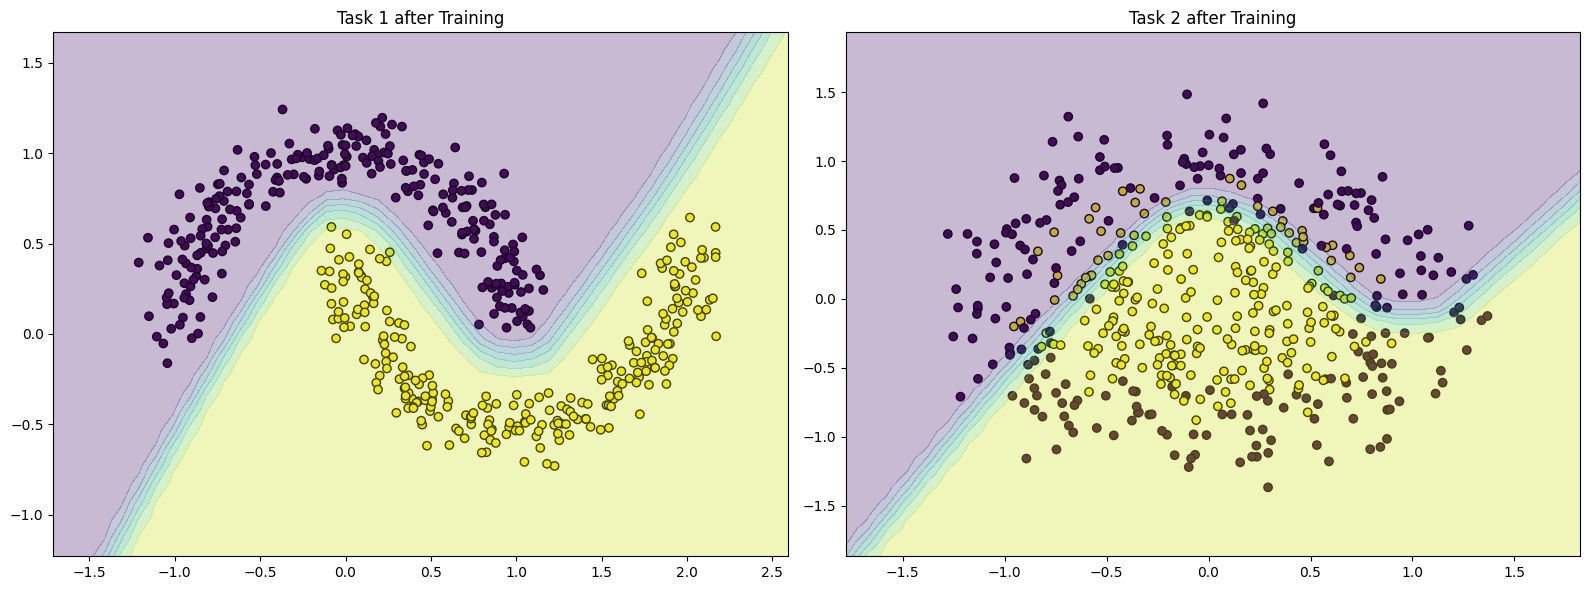

In [3]:
# Convert datasets to PyTorch tensors
X_task1 = torch.FloatTensor(X_task1)
y_task1 = torch.LongTensor(y_task1)
X_task2 = torch.FloatTensor(X_task2)
y_task2 = torch.LongTensor(y_task2)

# Create DataLoaders
batch_size = 32
train_loader_task1 = DataLoader(
    TensorDataset(X_task1, y_task1), batch_size=batch_size, shuffle=True
)
train_loader_task2 = DataLoader(
    TensorDataset(X_task2, y_task2), batch_size=batch_size, shuffle=True
)

# Define an MLP model without LoRA layers


class SimpleMLP(nn.Module):
    """Simple MLP model without LoRA layers."""

    def __init__(self, input_size=2, hidden_size=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, labels=None):  # pylint: disable=unused-argument
        """Forward pass of the MLP."""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Instantiate the model
model = SimpleMLP()

# Training loop for Task 1


def train_model(model, train_loader, num_epochs=100):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs to train.
    """
    device = torch.device("cpu")
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print loss every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


# Train the model on Task 1
print("Training on Task 1 without LoRA:")
train_model(model, train_loader_task1, num_epochs=20)

# Plot datasets with decision boundaries
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=model,
    titles=["Task 1 after Training", "Task 2 after Training"],
)

## Apply LoRA to the model using peft

In [4]:
# Apply LoRA to the model using peft
lora_config = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.01, target_modules=["fc1", "fc2"], bias="none"
)

peft_model = get_peft_model(model, lora_config)

## Setup FHE fine-tuning with LoraTrainer

In [5]:
# Update training parameters, including loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, peft_model.parameters()), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
training_args = {"gradient_accumulation_steps": 1}

# Set up LoRA training
lora_trainer = LoraTrainer(
    peft_model, optimizer=optimizer, loss_fn=loss_fn, training_args=training_args
)

# Prepare input data for calibration
batch_size_per_task = batch_size // 2
inputset = (
    torch.cat([X_task1[:batch_size_per_task], X_task2[:batch_size_per_task]]),
    torch.cat([y_task1[:batch_size_per_task], y_task2[:batch_size_per_task]]),
)

# Compile the model
lora_trainer.compile(inputset, n_bits=8)

2025-07-02 12:06:59,862 - INFO - === Starting new training session ===


LoRA layers detected in the model.


Compiling FHE layers:   0%|          | 0/3 [00:00<?, ?it/s]

Compilation device override, was 'cpu' -> change to 'cuda'
Compilation device override, was 'cpu' -> change to 'cuda'
Compilation device override, was 'cpu' -> change to 'cuda'


2025-07-02 12:07:00,091 - INFO - Compilation complete.


(0, 0)

In [6]:
# Fine-tune the model on Task 2 using LoRA
lora_trainer.train(train_loader_task2, num_epochs=10, fhe="execute")

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:02,138 - INFO - Step 1: loss=2.983022, avg_loss=2.983022


2025-07-02 12:07:02,140 - INFO - Average gradient magnitude: 0.045490


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:03,994 - INFO - Step 2: loss=2.714797, avg_loss=2.848910


2025-07-02 12:07:03,995 - INFO - Average gradient magnitude: 0.055881


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:05,893 - INFO - Step 3: loss=3.400522, avg_loss=3.032780


2025-07-02 12:07:05,894 - INFO - Average gradient magnitude: 0.116559


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:07,806 - INFO - Step 4: loss=3.154915, avg_loss=3.063314


2025-07-02 12:07:07,806 - INFO - Average gradient magnitude: 0.129288


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:09,655 - INFO - Step 5: loss=2.374049, avg_loss=2.925461


2025-07-02 12:07:09,656 - INFO - Average gradient magnitude: 0.102270


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:11,494 - INFO - Step 6: loss=1.399901, avg_loss=2.671201


2025-07-02 12:07:11,495 - INFO - Average gradient magnitude: 0.137591


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:13,350 - INFO - Step 7: loss=2.299220, avg_loss=2.618061


2025-07-02 12:07:13,352 - INFO - Average gradient magnitude: 0.122903


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:15,189 - INFO - Step 8: loss=3.874966, avg_loss=2.775174


2025-07-02 12:07:15,190 - INFO - Average gradient magnitude: 0.248744


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:17,017 - INFO - Step 9: loss=2.879502, avg_loss=2.786766


2025-07-02 12:07:17,019 - INFO - Average gradient magnitude: 0.154390


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:18,855 - INFO - Step 10: loss=2.658129, avg_loss=2.773902


2025-07-02 12:07:18,855 - INFO - Average gradient magnitude: 0.240021


2025-07-02 12:07:18,856 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:20,719 - INFO - Step 11: loss=1.402352, avg_loss=2.649216


2025-07-02 12:07:20,720 - INFO - Average gradient magnitude: 0.132233


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:22,564 - INFO - Step 12: loss=2.013148, avg_loss=2.596210


2025-07-02 12:07:22,565 - INFO - Average gradient magnitude: 0.196361


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:24,412 - INFO - Step 13: loss=3.256434, avg_loss=2.646997


2025-07-02 12:07:24,413 - INFO - Average gradient magnitude: 0.276839


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:26,236 - INFO - Step 14: loss=1.359904, avg_loss=2.555062


2025-07-02 12:07:26,239 - INFO - Average gradient magnitude: 0.130106


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:28,086 - INFO - Step 15: loss=1.240778, avg_loss=2.467443


2025-07-02 12:07:28,087 - INFO - Average gradient magnitude: 0.232516


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:29,250 - INFO - Step 16: loss=1.205164, avg_loss=2.388550


2025-07-02 12:07:29,252 - INFO - Average gradient magnitude: 0.213272


2025-07-02 12:07:29,256 - INFO - Epoch 1 completed. Avg Loss: 2.388550, FHE Mode: execute


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:31,073 - INFO - Step 17: loss=1.888701, avg_loss=1.888701


2025-07-02 12:07:31,074 - INFO - Average gradient magnitude: 0.388105


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:32,911 - INFO - Step 18: loss=2.237791, avg_loss=2.063246


2025-07-02 12:07:32,912 - INFO - Average gradient magnitude: 0.309982


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:34,740 - INFO - Step 19: loss=1.299807, avg_loss=1.808766


2025-07-02 12:07:34,744 - INFO - Average gradient magnitude: 0.183158


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:36,583 - INFO - Step 20: loss=1.781333, avg_loss=1.801908


2025-07-02 12:07:36,583 - INFO - Average gradient magnitude: 0.264557


2025-07-02 12:07:36,584 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:38,418 - INFO - Step 21: loss=1.126708, avg_loss=1.666868


2025-07-02 12:07:38,421 - INFO - Average gradient magnitude: 0.238591


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:40,262 - INFO - Step 22: loss=1.725627, avg_loss=1.676661


2025-07-02 12:07:40,263 - INFO - Average gradient magnitude: 0.280338


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:42,130 - INFO - Step 23: loss=1.817029, avg_loss=1.696714


2025-07-02 12:07:42,131 - INFO - Average gradient magnitude: 0.303914


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:43,968 - INFO - Step 24: loss=1.698469, avg_loss=1.696933


2025-07-02 12:07:43,969 - INFO - Average gradient magnitude: 0.370472


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:45,820 - INFO - Step 25: loss=1.034376, avg_loss=1.623316


2025-07-02 12:07:45,822 - INFO - Average gradient magnitude: 0.156739


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:47,662 - INFO - Step 26: loss=1.827243, avg_loss=1.643708


2025-07-02 12:07:47,663 - INFO - Average gradient magnitude: 0.422594


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:49,503 - INFO - Step 27: loss=0.740353, avg_loss=1.561585


2025-07-02 12:07:49,505 - INFO - Average gradient magnitude: 0.164675


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:51,329 - INFO - Step 28: loss=1.402921, avg_loss=1.548363


2025-07-02 12:07:51,332 - INFO - Average gradient magnitude: 0.400769


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:53,162 - INFO - Step 29: loss=1.802702, avg_loss=1.567928


2025-07-02 12:07:53,164 - INFO - Average gradient magnitude: 0.484718


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:55,014 - INFO - Step 30: loss=2.246276, avg_loss=1.616381


2025-07-02 12:07:55,015 - INFO - Average gradient magnitude: 0.669566


2025-07-02 12:07:55,016 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:56,829 - INFO - Step 31: loss=1.792769, avg_loss=1.628140


2025-07-02 12:07:56,830 - INFO - Average gradient magnitude: 0.485152


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:58,009 - INFO - Step 32: loss=0.582126, avg_loss=1.562764


2025-07-02 12:07:58,011 - INFO - Average gradient magnitude: 0.118187


2025-07-02 12:07:58,013 - INFO - Epoch 2 completed. Avg Loss: 1.562764, FHE Mode: execute


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:07:59,848 - INFO - Step 33: loss=1.699811, avg_loss=1.699811


2025-07-02 12:07:59,849 - INFO - Average gradient magnitude: 0.395175


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:01,688 - INFO - Step 34: loss=0.850926, avg_loss=1.275369


2025-07-02 12:08:01,689 - INFO - Average gradient magnitude: 0.314470


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:03,596 - INFO - Step 35: loss=0.591825, avg_loss=1.047521


2025-07-02 12:08:03,597 - INFO - Average gradient magnitude: 0.105795


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:05,461 - INFO - Step 36: loss=1.435197, avg_loss=1.144440


2025-07-02 12:08:05,462 - INFO - Average gradient magnitude: 0.394997


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:07,288 - INFO - Step 37: loss=0.517340, avg_loss=1.019020


2025-07-02 12:08:07,289 - INFO - Average gradient magnitude: 0.175849


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:09,126 - INFO - Step 38: loss=1.053009, avg_loss=1.024685


2025-07-02 12:08:09,130 - INFO - Average gradient magnitude: 0.287324


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:10,949 - INFO - Step 39: loss=0.526010, avg_loss=0.953446


2025-07-02 12:08:10,950 - INFO - Average gradient magnitude: 0.099519


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:12,821 - INFO - Step 40: loss=0.601653, avg_loss=0.909472


2025-07-02 12:08:12,822 - INFO - Average gradient magnitude: 0.172542


2025-07-02 12:08:12,823 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:14,696 - INFO - Step 41: loss=1.506674, avg_loss=0.975827


2025-07-02 12:08:14,697 - INFO - Average gradient magnitude: 0.669648


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:16,561 - INFO - Step 42: loss=0.981909, avg_loss=0.976436


2025-07-02 12:08:16,562 - INFO - Average gradient magnitude: 0.325720


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:18,444 - INFO - Step 43: loss=0.329335, avg_loss=0.917608


2025-07-02 12:08:18,445 - INFO - Average gradient magnitude: 0.098826


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:20,291 - INFO - Step 44: loss=0.901595, avg_loss=0.916274


2025-07-02 12:08:20,292 - INFO - Average gradient magnitude: 0.188251


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:22,152 - INFO - Step 45: loss=0.742388, avg_loss=0.902898


2025-07-02 12:08:22,153 - INFO - Average gradient magnitude: 0.272826


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:23,997 - INFO - Step 46: loss=0.415527, avg_loss=0.868086


2025-07-02 12:08:23,998 - INFO - Average gradient magnitude: 0.170158


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:25,839 - INFO - Step 47: loss=0.304636, avg_loss=0.830522


2025-07-02 12:08:25,840 - INFO - Average gradient magnitude: 0.126754


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:27,028 - INFO - Step 48: loss=0.587809, avg_loss=0.815353


2025-07-02 12:08:27,029 - INFO - Average gradient magnitude: 0.202008


2025-07-02 12:08:27,032 - INFO - Epoch 3 completed. Avg Loss: 0.815353, FHE Mode: execute


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:28,875 - INFO - Step 49: loss=0.454426, avg_loss=0.454426


2025-07-02 12:08:28,876 - INFO - Average gradient magnitude: 0.241879


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:30,736 - INFO - Step 50: loss=0.178918, avg_loss=0.316672


2025-07-02 12:08:30,737 - INFO - Average gradient magnitude: 0.104298


2025-07-02 12:08:30,737 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:32,596 - INFO - Step 51: loss=0.393130, avg_loss=0.342158


2025-07-02 12:08:32,597 - INFO - Average gradient magnitude: 0.157900


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:34,442 - INFO - Step 52: loss=0.627492, avg_loss=0.413491


2025-07-02 12:08:34,444 - INFO - Average gradient magnitude: 0.182522


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:36,285 - INFO - Step 53: loss=0.571933, avg_loss=0.445180


2025-07-02 12:08:36,287 - INFO - Average gradient magnitude: 0.128057


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:38,129 - INFO - Step 54: loss=0.840344, avg_loss=0.511040


2025-07-02 12:08:38,130 - INFO - Average gradient magnitude: 0.204602


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:39,967 - INFO - Step 55: loss=0.391592, avg_loss=0.493976


2025-07-02 12:08:39,968 - INFO - Average gradient magnitude: 0.351909


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:41,815 - INFO - Step 56: loss=0.474403, avg_loss=0.491530


2025-07-02 12:08:41,817 - INFO - Average gradient magnitude: 0.295082


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:43,667 - INFO - Step 57: loss=0.583519, avg_loss=0.501751


2025-07-02 12:08:43,669 - INFO - Average gradient magnitude: 0.228412


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:45,505 - INFO - Step 58: loss=0.696179, avg_loss=0.521194


2025-07-02 12:08:45,506 - INFO - Average gradient magnitude: 0.309479


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:47,344 - INFO - Step 59: loss=0.415806, avg_loss=0.511613


2025-07-02 12:08:47,345 - INFO - Average gradient magnitude: 0.120803


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:49,171 - INFO - Step 60: loss=0.384411, avg_loss=0.501013


2025-07-02 12:08:49,172 - INFO - Average gradient magnitude: 0.094549


2025-07-02 12:08:49,173 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:50,990 - INFO - Step 61: loss=0.768432, avg_loss=0.521583


2025-07-02 12:08:50,991 - INFO - Average gradient magnitude: 0.359422


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:52,828 - INFO - Step 62: loss=0.669465, avg_loss=0.532146


2025-07-02 12:08:52,829 - INFO - Average gradient magnitude: 0.623847


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:54,645 - INFO - Step 63: loss=0.611500, avg_loss=0.537437


2025-07-02 12:08:54,646 - INFO - Average gradient magnitude: 0.272201


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:55,797 - INFO - Step 64: loss=0.221662, avg_loss=0.517701


2025-07-02 12:08:55,798 - INFO - Average gradient magnitude: 0.091699


2025-07-02 12:08:55,800 - INFO - Epoch 4 completed. Avg Loss: 0.517701, FHE Mode: execute


Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:57,636 - INFO - Step 65: loss=0.545383, avg_loss=0.545383


2025-07-02 12:08:57,637 - INFO - Average gradient magnitude: 0.354444


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:08:59,489 - INFO - Step 66: loss=0.312895, avg_loss=0.429139


2025-07-02 12:08:59,490 - INFO - Average gradient magnitude: 0.086229


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:01,369 - INFO - Step 67: loss=0.287882, avg_loss=0.382053


2025-07-02 12:09:01,370 - INFO - Average gradient magnitude: 0.174430


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:03,226 - INFO - Step 68: loss=0.588943, avg_loss=0.433776


2025-07-02 12:09:03,227 - INFO - Average gradient magnitude: 0.171962


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:05,098 - INFO - Step 69: loss=0.440805, avg_loss=0.435182


2025-07-02 12:09:05,100 - INFO - Average gradient magnitude: 0.135506


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:06,961 - INFO - Step 70: loss=0.966590, avg_loss=0.523750


2025-07-02 12:09:06,962 - INFO - Average gradient magnitude: 0.329220


2025-07-02 12:09:06,963 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:08,808 - INFO - Step 71: loss=0.493836, avg_loss=0.519476


2025-07-02 12:09:08,810 - INFO - Average gradient magnitude: 0.170424


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:10,654 - INFO - Step 72: loss=0.452875, avg_loss=0.511151


2025-07-02 12:09:10,655 - INFO - Average gradient magnitude: 0.101867


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:12,483 - INFO - Step 73: loss=0.384745, avg_loss=0.497106


2025-07-02 12:09:12,484 - INFO - Average gradient magnitude: 0.217848


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:14,322 - INFO - Step 74: loss=0.440801, avg_loss=0.491476


2025-07-02 12:09:14,323 - INFO - Average gradient magnitude: 0.215943


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:16,160 - INFO - Step 75: loss=0.309630, avg_loss=0.474944


2025-07-02 12:09:16,161 - INFO - Average gradient magnitude: 0.071840


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:17,994 - INFO - Step 76: loss=0.308688, avg_loss=0.461089


2025-07-02 12:09:17,995 - INFO - Average gradient magnitude: 0.108904


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:19,826 - INFO - Step 77: loss=0.169218, avg_loss=0.438638


2025-07-02 12:09:19,826 - INFO - Average gradient magnitude: 0.052192


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:21,676 - INFO - Step 78: loss=0.228031, avg_loss=0.423594


2025-07-02 12:09:21,677 - INFO - Average gradient magnitude: 0.143392


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:23,524 - INFO - Step 79: loss=0.235620, avg_loss=0.411063


2025-07-02 12:09:23,525 - INFO - Average gradient magnitude: 0.127110


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:24,683 - INFO - Step 80: loss=0.355380, avg_loss=0.407583


2025-07-02 12:09:24,684 - INFO - Average gradient magnitude: 0.245862


2025-07-02 12:09:24,685 - INFO - No evaluation data or metric function provided.


2025-07-02 12:09:24,686 - INFO - Epoch 5 completed. Avg Loss: 0.407583, FHE Mode: execute


Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:26,527 - INFO - Step 81: loss=0.187420, avg_loss=0.187420


2025-07-02 12:09:26,527 - INFO - Average gradient magnitude: 0.158001


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:28,364 - INFO - Step 82: loss=0.328243, avg_loss=0.257832


2025-07-02 12:09:28,365 - INFO - Average gradient magnitude: 0.099909


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:30,201 - INFO - Step 83: loss=0.401144, avg_loss=0.305602


2025-07-02 12:09:30,202 - INFO - Average gradient magnitude: 0.137346


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:32,047 - INFO - Step 84: loss=0.444166, avg_loss=0.340243


2025-07-02 12:09:32,048 - INFO - Average gradient magnitude: 0.078070


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:33,866 - INFO - Step 85: loss=0.163632, avg_loss=0.304921


2025-07-02 12:09:33,867 - INFO - Average gradient magnitude: 0.078310


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:35,702 - INFO - Step 86: loss=0.494887, avg_loss=0.336582


2025-07-02 12:09:35,703 - INFO - Average gradient magnitude: 0.354065


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:37,557 - INFO - Step 87: loss=0.353141, avg_loss=0.338948


2025-07-02 12:09:37,559 - INFO - Average gradient magnitude: 0.202816


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:39,403 - INFO - Step 88: loss=0.281555, avg_loss=0.331773


2025-07-02 12:09:39,404 - INFO - Average gradient magnitude: 0.167217


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:41,249 - INFO - Step 89: loss=0.232591, avg_loss=0.320753


2025-07-02 12:09:41,250 - INFO - Average gradient magnitude: 0.087037


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:43,072 - INFO - Step 90: loss=0.352010, avg_loss=0.323879


2025-07-02 12:09:43,073 - INFO - Average gradient magnitude: 0.072653


2025-07-02 12:09:43,073 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:44,895 - INFO - Step 91: loss=0.491097, avg_loss=0.339080


2025-07-02 12:09:44,896 - INFO - Average gradient magnitude: 0.202839


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:46,734 - INFO - Step 92: loss=0.386000, avg_loss=0.342990


2025-07-02 12:09:46,736 - INFO - Average gradient magnitude: 0.127645


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:48,626 - INFO - Step 93: loss=0.131703, avg_loss=0.326738


2025-07-02 12:09:48,627 - INFO - Average gradient magnitude: 0.086134


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:50,465 - INFO - Step 94: loss=0.432376, avg_loss=0.334283


2025-07-02 12:09:50,466 - INFO - Average gradient magnitude: 0.152512


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:52,307 - INFO - Step 95: loss=0.396905, avg_loss=0.338458


2025-07-02 12:09:52,308 - INFO - Average gradient magnitude: 0.094188


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:53,473 - INFO - Step 96: loss=0.306745, avg_loss=0.336476


2025-07-02 12:09:53,474 - INFO - Average gradient magnitude: 0.211290


2025-07-02 12:09:53,477 - INFO - Epoch 6 completed. Avg Loss: 0.336476, FHE Mode: execute


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:55,315 - INFO - Step 97: loss=0.258877, avg_loss=0.258877


2025-07-02 12:09:55,316 - INFO - Average gradient magnitude: 0.135519


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:57,148 - INFO - Step 98: loss=0.476487, avg_loss=0.367682


2025-07-02 12:09:57,149 - INFO - Average gradient magnitude: 0.103265


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:09:58,979 - INFO - Step 99: loss=0.332024, avg_loss=0.355796


2025-07-02 12:09:58,980 - INFO - Average gradient magnitude: 0.126607


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:00,822 - INFO - Step 100: loss=0.281371, avg_loss=0.337190


2025-07-02 12:10:00,823 - INFO - Average gradient magnitude: 0.131449


2025-07-02 12:10:00,824 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:02,679 - INFO - Step 101: loss=0.406451, avg_loss=0.351042


2025-07-02 12:10:02,680 - INFO - Average gradient magnitude: 0.137470


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:04,515 - INFO - Step 102: loss=0.240500, avg_loss=0.332618


2025-07-02 12:10:04,516 - INFO - Average gradient magnitude: 0.100273


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:06,361 - INFO - Step 103: loss=0.244441, avg_loss=0.320022


2025-07-02 12:10:06,362 - INFO - Average gradient magnitude: 0.098635


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:08,216 - INFO - Step 104: loss=0.336057, avg_loss=0.322026


2025-07-02 12:10:08,217 - INFO - Average gradient magnitude: 0.262309


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:10,069 - INFO - Step 105: loss=0.139490, avg_loss=0.301744


2025-07-02 12:10:10,072 - INFO - Average gradient magnitude: 0.096513


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:11,918 - INFO - Step 106: loss=0.478837, avg_loss=0.319453


2025-07-02 12:10:11,920 - INFO - Average gradient magnitude: 0.176876


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:13,777 - INFO - Step 107: loss=0.376467, avg_loss=0.324636


2025-07-02 12:10:13,780 - INFO - Average gradient magnitude: 0.222902


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:15,637 - INFO - Step 108: loss=0.309930, avg_loss=0.323411


2025-07-02 12:10:15,638 - INFO - Average gradient magnitude: 0.238708


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:17,464 - INFO - Step 109: loss=0.256039, avg_loss=0.318228


2025-07-02 12:10:17,465 - INFO - Average gradient magnitude: 0.152556


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:19,295 - INFO - Step 110: loss=0.364204, avg_loss=0.321512


2025-07-02 12:10:19,296 - INFO - Average gradient magnitude: 0.102540


2025-07-02 12:10:19,296 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:21,114 - INFO - Step 111: loss=0.207410, avg_loss=0.313906


2025-07-02 12:10:21,116 - INFO - Average gradient magnitude: 0.136450


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:22,271 - INFO - Step 112: loss=0.150604, avg_loss=0.303699


2025-07-02 12:10:22,272 - INFO - Average gradient magnitude: 0.167598


2025-07-02 12:10:22,274 - INFO - Epoch 7 completed. Avg Loss: 0.303699, FHE Mode: execute


Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:24,087 - INFO - Step 113: loss=0.330405, avg_loss=0.330405


2025-07-02 12:10:24,089 - INFO - Average gradient magnitude: 0.050067


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:25,906 - INFO - Step 114: loss=0.236064, avg_loss=0.283234


2025-07-02 12:10:25,907 - INFO - Average gradient magnitude: 0.089857


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:27,743 - INFO - Step 115: loss=0.157934, avg_loss=0.241467


2025-07-02 12:10:27,744 - INFO - Average gradient magnitude: 0.091046


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:29,561 - INFO - Step 116: loss=0.364118, avg_loss=0.272130


2025-07-02 12:10:29,562 - INFO - Average gradient magnitude: 0.145151


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:31,397 - INFO - Step 117: loss=0.284289, avg_loss=0.274562


2025-07-02 12:10:31,398 - INFO - Average gradient magnitude: 0.184201


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:33,211 - INFO - Step 118: loss=0.418892, avg_loss=0.298617


2025-07-02 12:10:33,212 - INFO - Average gradient magnitude: 0.099788


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:35,036 - INFO - Step 119: loss=0.211775, avg_loss=0.286211


2025-07-02 12:10:35,037 - INFO - Average gradient magnitude: 0.109497


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:36,863 - INFO - Step 120: loss=0.325475, avg_loss=0.291119


2025-07-02 12:10:36,864 - INFO - Average gradient magnitude: 0.099255


2025-07-02 12:10:36,865 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:38,685 - INFO - Step 121: loss=0.220695, avg_loss=0.283294


2025-07-02 12:10:38,686 - INFO - Average gradient magnitude: 0.041139


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:40,521 - INFO - Step 122: loss=0.514256, avg_loss=0.306390


2025-07-02 12:10:40,522 - INFO - Average gradient magnitude: 0.380365


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:42,365 - INFO - Step 123: loss=0.310764, avg_loss=0.306788


2025-07-02 12:10:42,366 - INFO - Average gradient magnitude: 0.228522


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:44,212 - INFO - Step 124: loss=0.266884, avg_loss=0.303463


2025-07-02 12:10:44,213 - INFO - Average gradient magnitude: 0.218311


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:46,061 - INFO - Step 125: loss=0.178938, avg_loss=0.293884


2025-07-02 12:10:46,063 - INFO - Average gradient magnitude: 0.086000


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:48,018 - INFO - Step 126: loss=0.219860, avg_loss=0.288596


2025-07-02 12:10:48,021 - INFO - Average gradient magnitude: 0.083966


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:49,866 - INFO - Step 127: loss=0.275914, avg_loss=0.287751


2025-07-02 12:10:49,867 - INFO - Average gradient magnitude: 0.163537


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:51,049 - INFO - Step 128: loss=0.259478, avg_loss=0.285984


2025-07-02 12:10:51,050 - INFO - Average gradient magnitude: 0.190798


2025-07-02 12:10:51,052 - INFO - Epoch 8 completed. Avg Loss: 0.285984, FHE Mode: execute


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:52,901 - INFO - Step 129: loss=0.283838, avg_loss=0.283838


2025-07-02 12:10:52,902 - INFO - Average gradient magnitude: 0.224923


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:54,729 - INFO - Step 130: loss=0.286148, avg_loss=0.284993


2025-07-02 12:10:54,732 - INFO - Average gradient magnitude: 0.244167


2025-07-02 12:10:54,732 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:56,598 - INFO - Step 131: loss=0.408748, avg_loss=0.326245


2025-07-02 12:10:56,601 - INFO - Average gradient magnitude: 0.149906


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:10:58,441 - INFO - Step 132: loss=0.314403, avg_loss=0.323284


2025-07-02 12:10:58,442 - INFO - Average gradient magnitude: 0.223743


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:00,309 - INFO - Step 133: loss=0.371280, avg_loss=0.332883


2025-07-02 12:11:00,311 - INFO - Average gradient magnitude: 0.091566


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:02,188 - INFO - Step 134: loss=0.267737, avg_loss=0.322026


2025-07-02 12:11:02,192 - INFO - Average gradient magnitude: 0.121303


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:04,036 - INFO - Step 135: loss=0.162774, avg_loss=0.299275


2025-07-02 12:11:04,037 - INFO - Average gradient magnitude: 0.070671


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:05,902 - INFO - Step 136: loss=0.212485, avg_loss=0.288427


2025-07-02 12:11:05,903 - INFO - Average gradient magnitude: 0.098752


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:07,773 - INFO - Step 137: loss=0.295285, avg_loss=0.289189


2025-07-02 12:11:07,774 - INFO - Average gradient magnitude: 0.097146


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:09,623 - INFO - Step 138: loss=0.114453, avg_loss=0.271715


2025-07-02 12:11:09,624 - INFO - Average gradient magnitude: 0.163315


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:11,479 - INFO - Step 139: loss=0.356978, avg_loss=0.279466


2025-07-02 12:11:11,482 - INFO - Average gradient magnitude: 0.391270


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:13,345 - INFO - Step 140: loss=0.177258, avg_loss=0.270949


2025-07-02 12:11:13,348 - INFO - Average gradient magnitude: 0.073928


2025-07-02 12:11:13,348 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:15,185 - INFO - Step 141: loss=0.233522, avg_loss=0.268070


2025-07-02 12:11:15,188 - INFO - Average gradient magnitude: 0.097118


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:17,018 - INFO - Step 142: loss=0.232608, avg_loss=0.265537


2025-07-02 12:11:17,020 - INFO - Average gradient magnitude: 0.046837


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:18,867 - INFO - Step 143: loss=0.295285, avg_loss=0.267520


2025-07-02 12:11:18,872 - INFO - Average gradient magnitude: 0.088741


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:20,078 - INFO - Step 144: loss=0.486370, avg_loss=0.281198


2025-07-02 12:11:20,081 - INFO - Average gradient magnitude: 0.279248


2025-07-02 12:11:20,085 - INFO - Epoch 9 completed. Avg Loss: 0.281198, FHE Mode: execute


Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:21,958 - INFO - Step 145: loss=0.314927, avg_loss=0.314927


2025-07-02 12:11:21,960 - INFO - Average gradient magnitude: 0.219279


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:23,847 - INFO - Step 146: loss=0.428386, avg_loss=0.371656


2025-07-02 12:11:23,849 - INFO - Average gradient magnitude: 0.158168


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:25,720 - INFO - Step 147: loss=0.445918, avg_loss=0.396410


2025-07-02 12:11:25,721 - INFO - Average gradient magnitude: 0.306377


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:27,565 - INFO - Step 148: loss=0.287483, avg_loss=0.369178


2025-07-02 12:11:27,566 - INFO - Average gradient magnitude: 0.287162


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:29,419 - INFO - Step 149: loss=0.277295, avg_loss=0.350802


2025-07-02 12:11:29,421 - INFO - Average gradient magnitude: 0.096152


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:31,266 - INFO - Step 150: loss=0.185157, avg_loss=0.323194


2025-07-02 12:11:31,268 - INFO - Average gradient magnitude: 0.097400


2025-07-02 12:11:31,269 - INFO - No evaluation data or metric function provided.


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:33,137 - INFO - Step 151: loss=0.418507, avg_loss=0.336810


2025-07-02 12:11:33,138 - INFO - Average gradient magnitude: 0.165433


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:35,043 - INFO - Step 152: loss=0.293838, avg_loss=0.331439


2025-07-02 12:11:35,045 - INFO - Average gradient magnitude: 0.390688


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:36,944 - INFO - Step 153: loss=0.327195, avg_loss=0.330967


2025-07-02 12:11:36,948 - INFO - Average gradient magnitude: 0.293317


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:38,787 - INFO - Step 154: loss=0.565060, avg_loss=0.354377


2025-07-02 12:11:38,788 - INFO - Average gradient magnitude: 0.252297


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:40,679 - INFO - Step 155: loss=0.345868, avg_loss=0.353603


2025-07-02 12:11:40,681 - INFO - Average gradient magnitude: 0.359878


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:42,523 - INFO - Step 156: loss=0.336216, avg_loss=0.352154


2025-07-02 12:11:42,525 - INFO - Average gradient magnitude: 0.112229


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:44,368 - INFO - Step 157: loss=0.308506, avg_loss=0.348796


2025-07-02 12:11:44,372 - INFO - Average gradient magnitude: 0.106365


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:46,225 - INFO - Step 158: loss=0.292406, avg_loss=0.344769


2025-07-02 12:11:46,227 - INFO - Average gradient magnitude: 0.323899


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:48,098 - INFO - Step 159: loss=0.324415, avg_loss=0.343412


2025-07-02 12:11:48,099 - INFO - Average gradient magnitude: 0.190213


FHE Modules Inference:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-02 12:11:49,317 - INFO - Step 160: loss=0.279130, avg_loss=0.339394


2025-07-02 12:11:49,318 - INFO - Average gradient magnitude: 0.081866


2025-07-02 12:11:49,318 - INFO - No evaluation data or metric function provided.


2025-07-02 12:11:49,321 - INFO - Epoch 10 completed. Avg Loss: 0.339394, FHE Mode: execute


2025-07-02 12:11:49,322 - INFO - Training completed. Final Avg Loss: 0.339394, FHE Mode: execute


## Visualize fine-tuned model

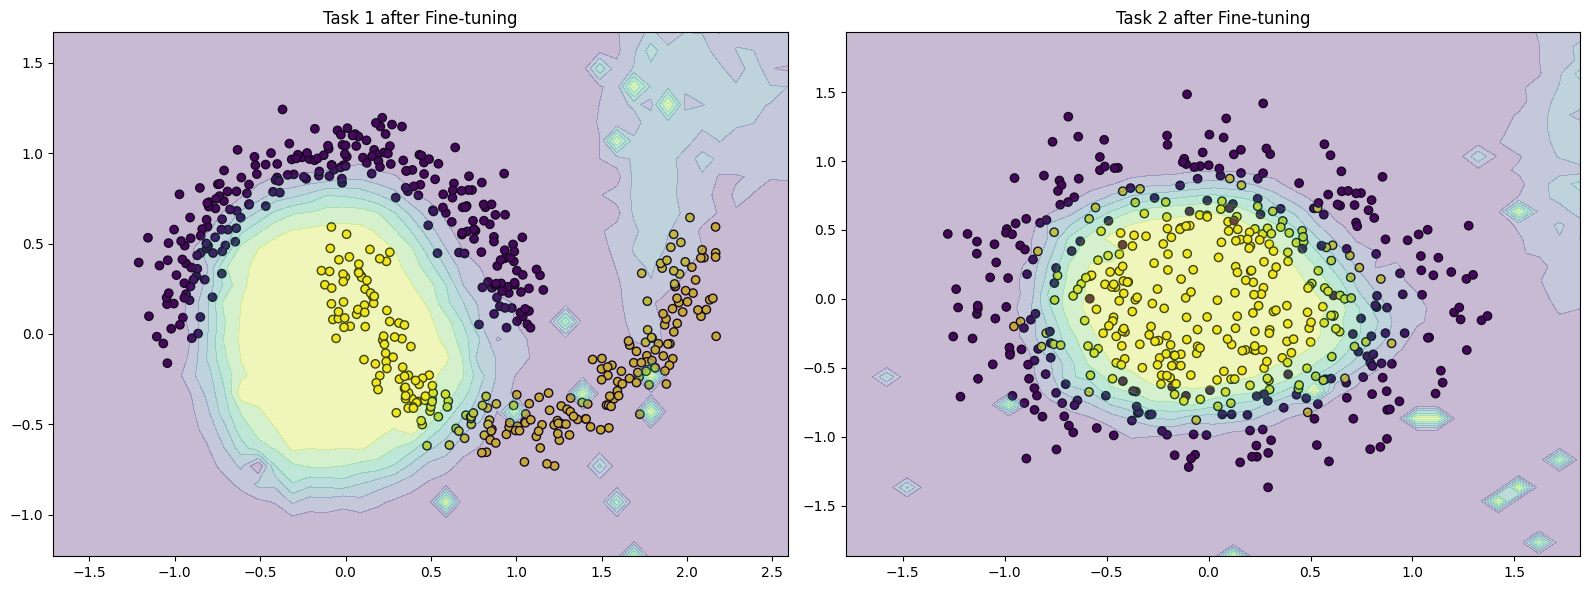

In [7]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Disable LoRA adapters to see the original model

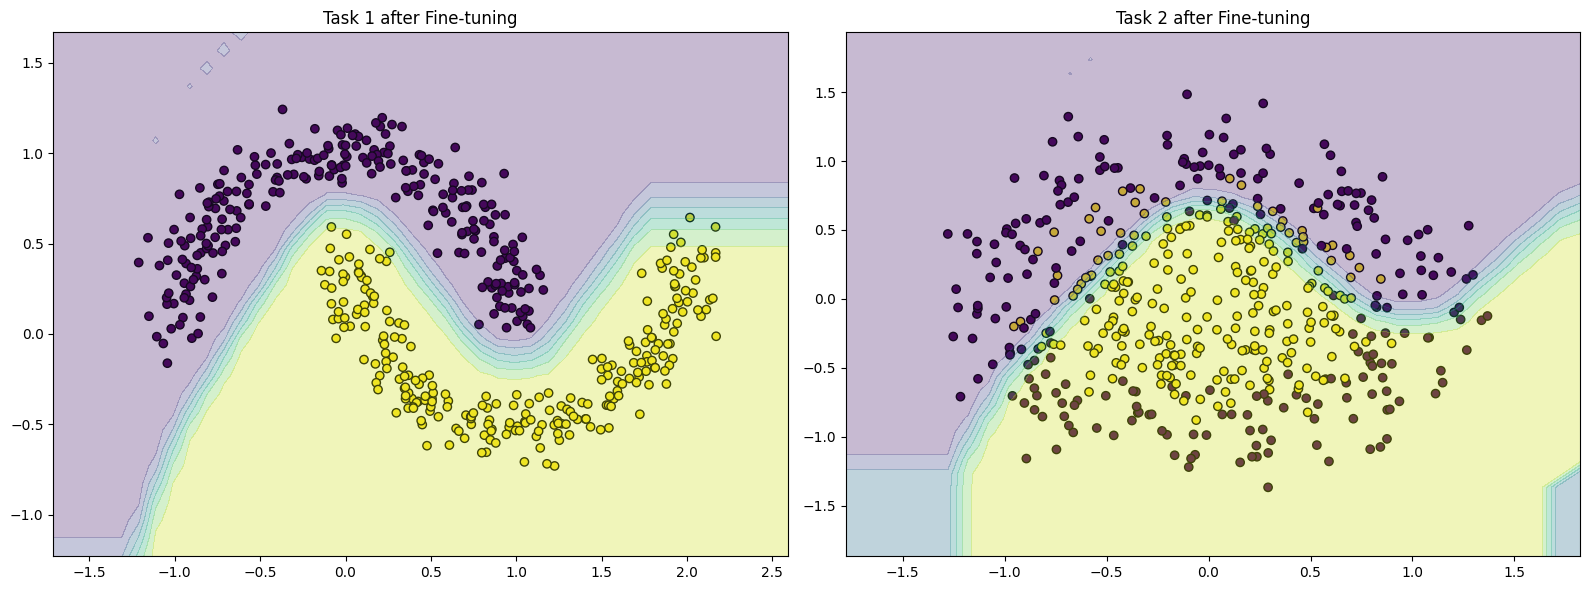

In [8]:
# Disable LoRA adapters
peft_model.disable_adapter_layers()

# Plot datasets with decision boundaries after fine-tuning
plot_datasets_and_boundaries(
    X_task1.numpy(),
    y_task1.numpy(),
    X_task2.numpy(),
    y_task2.numpy(),
    model=peft_model,
    titles=["Task 1 after Fine-tuning", "Task 2 after Fine-tuning"],
)

## Print statistics and save the model

In [9]:
# Enable LoRA adapters (already enabled by default)
peft_model.enable_adapter_layers()

# Print trainable (lora) parameters
peft_model.print_trainable_parameters()

# Save the model and remove all layers that will be done on the server
path = Path("lora_mlp")

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

lora_trainer.save_and_clear_private_info(path)

# At this point, the client's model only contains the trainable parameters of the LoRA layers.
peft_model.print_trainable_parameters()

2025-07-02 12:15:46,585 - INFO - Model saved at lora_mlp


trainable params: 260 || all params: 902 || trainable%: 28.8248
trainable params: 260 || all params: 260 || trainable%: 100.0000


## Conclusion

This notebook demonstrates how Low-Rank Adaptation (LoRA) facilitates parameter-efficient fine-tuning of models on private data. By leveraging FHE, the training process ensures that sensitive data and private model updates remains secure.
 
**Key Takeaways:**
 
- **Efficiency with LoRA:** While this example utilizes an MLP model with a relatively high proportion of LoRA weights due to its simplicity, the approach scales effectively to larger models like large language models (LLMs). In such cases, LoRA typically accounts for **less than one percent** of the total model parameters, ensuring minimal memory and computational overhead on the client side.
- **Scalability and Practicality:** The hybrid approach demonstrated here is particularly beneficial for scenarios where client devices have limited resources. Memory heavy computations are offloaded to a secure server and the client handles only the lightweight LoRA adjustments locally.